In [1]:
from mpc import *
import gc

In [2]:
total_time = 86400  # Total simulation time 24h (86400s)
t_step = 60  # Read states every 1m (60s)
steps = int(total_time/t_step)  # Number of control step total_time/t_step 1440
avg_period = 14400  # Get average trajectory every 240 m (14400s)

x_0 = np.array([30, 50, 400, 125, 0, 0])


## Control loop
Control loop for the stochastic model. The simulation is repeated for a certain number of episodes.

In [3]:
%%capture
episodes = 10

setup_mpc = {
    'n_robust': 1,
    'n_horizon': 10,
    't_step': t_step,
    'store_full_solution': True,
}

for e in range(episodes):
    
    model = template_model(stochasticity=True)
    mpc = template_mpc(model, setup_mpc=setup_mpc)
    simulator = template_simulator(model, t_step)
    estimator = do_mpc.estimator.StateFeedback(model)

    simulator.reset_history()

    mpc.x0 = x_0
    simulator.x0 = x_0
    estimator.x0 = x_0

    mpc.set_initial_guess()

    for k in range(steps):

        u = mpc.make_step(x_0)

        v0 = np.random.randn(model.n_v, 1)
        w0 = np.random.randn(model.n_w, 1)

        if (mpc.t0 - t_step) % 900 == 0:
        
            y_next = simulator.make_step(u, v0, w0)    
            x_0 = estimator.make_step(y_next)

    data = save_results(mpc, avg_period, t_step)
    compute_performance_metrics(data, total_time, t_step, avg_period)
    export_results(data, 'stochastic', 'result' + str(e), 'w')

    del model, mpc, simulator, estimator
    if e != (episodes - 1):
        del data
    gc.collect()


## Compute performance metrics and plot results

------------------------------ PERFORMANCES METRICS ------------------------------
ISE: 5.67e+03
ITAE: 1.22e+08
------------------------------ PLOT RESULTS ------------------------------


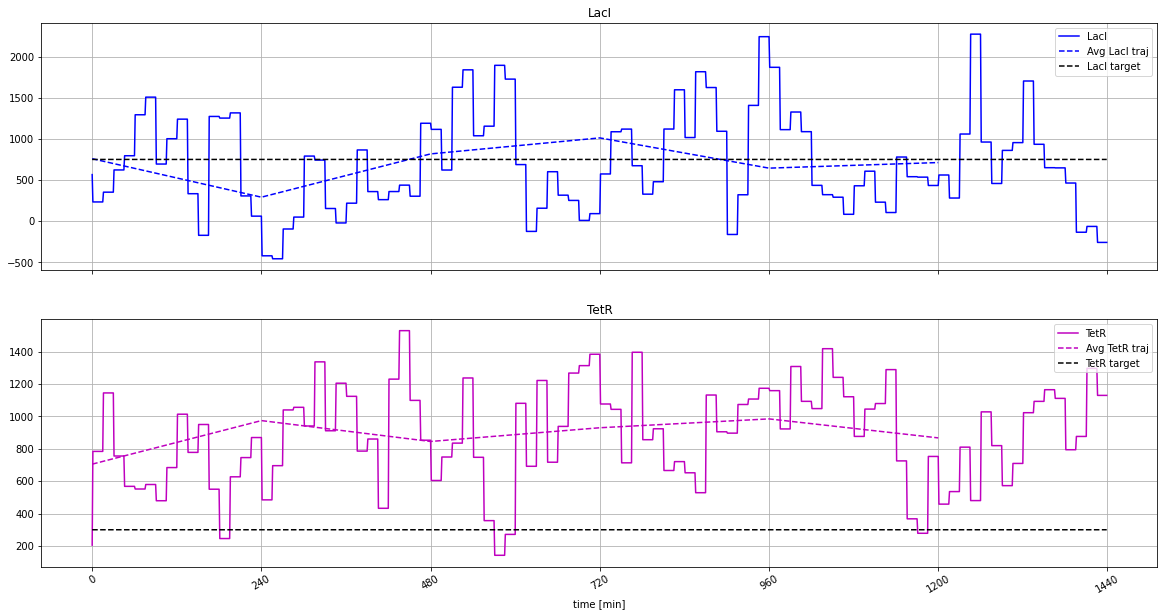

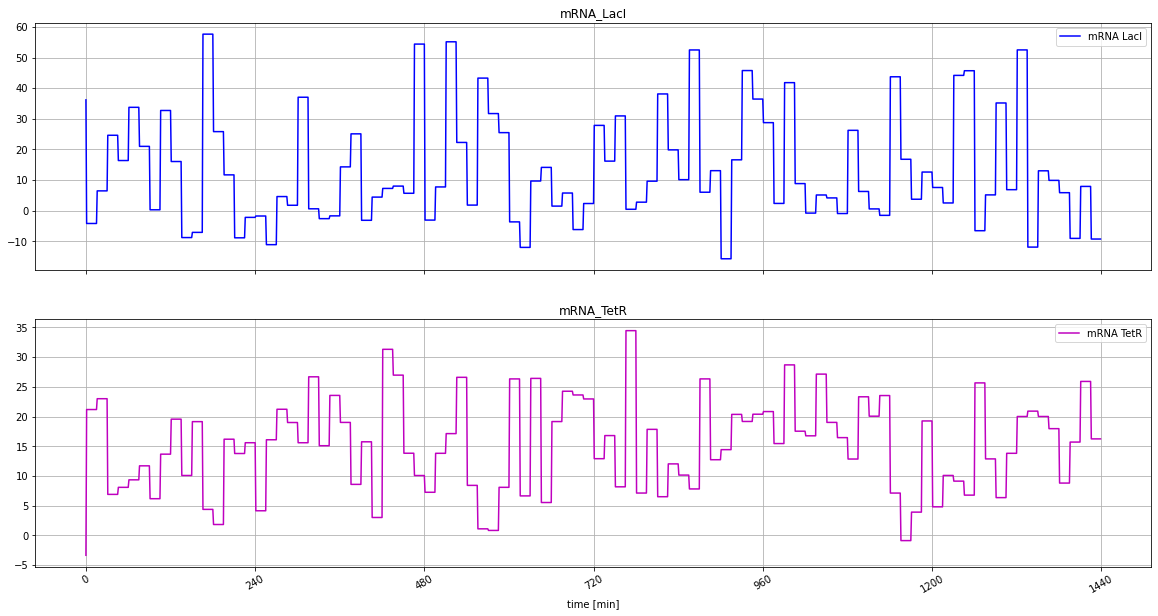

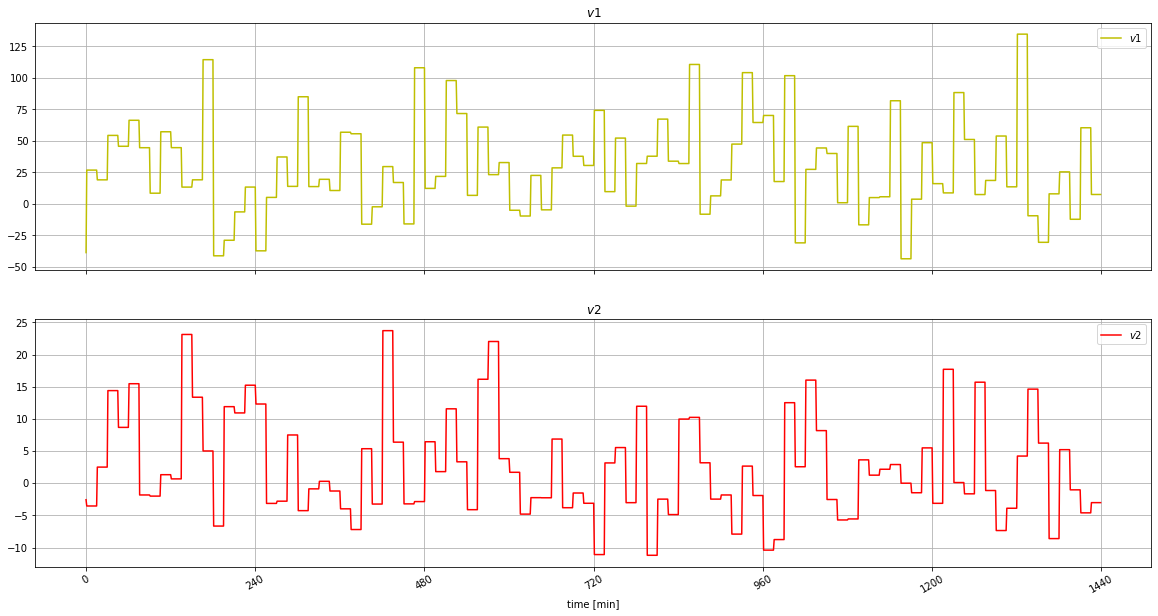

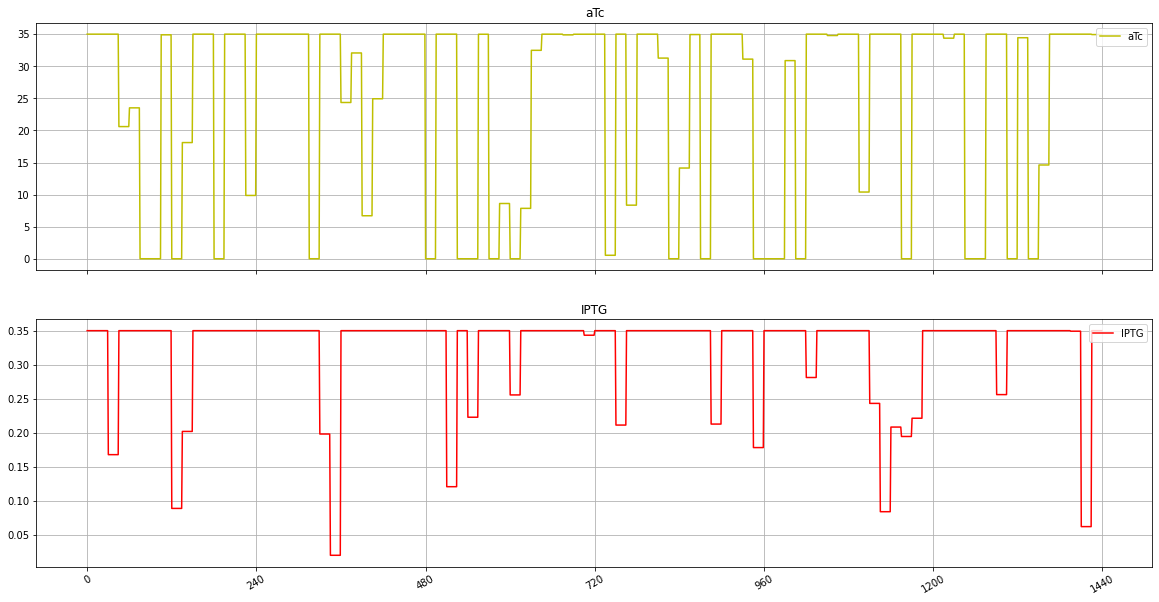

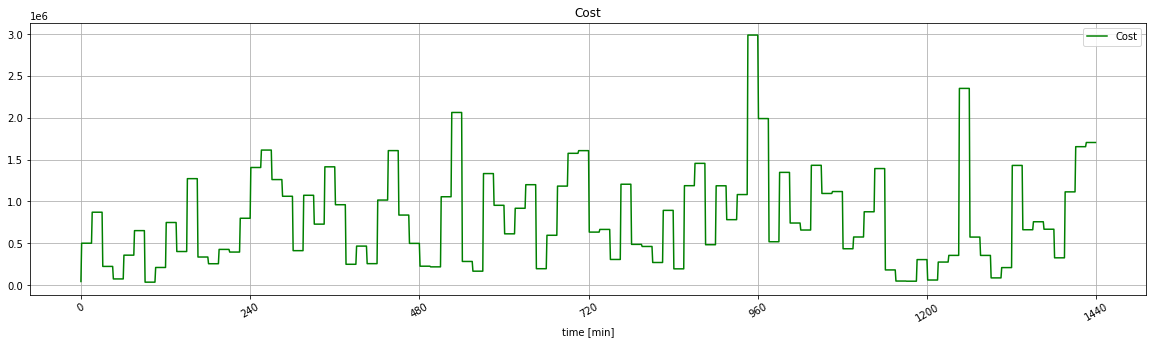

In [4]:
print('------------------------------ PERFORMANCES METRICS ------------------------------')
ISE, ITAE = compute_performance_metrics(data, total_time, t_step, avg_period)
print('ISE:', format(ISE, '.2e'))
print('ITAE:', format(ITAE, '.2e'))

print('------------------------------ PLOT RESULTS ------------------------------')
figures, lines = plot_results(data, total_time, avg_period)


## Plots animation

In [5]:
animate_results('stochastic', 'proteins', update_protein, figures[0], (data, lines[0:6], np.arange(0, total_time, avg_period)), steps)
animate_results('stochastic', 'mRNAs', update_mRNA, figures[1], (data, lines[6:8]), steps)
animate_results('stochastic', 'internal_inducers', update_internal_inducers, figures[2], (data, lines[8:10]), steps)
animate_results('stochastic', 'external_inducers', update_external_inducers, figures[3], (data, lines[10:12]), steps)
animate_results('stochastic', 'cost', update_cost, figures[4], (data, lines[12:13]), steps)

# Results mean and std

In this section the mean and the standard deviation of the state trajectories are computed and plotted, starting from the results of the previous simulations.

In [6]:
samples = int(total_time/t_step)

x1 = np.empty((episodes, samples))
x2 = np.empty((episodes, samples))
x3 = np.empty((episodes, samples))
x4 = np.empty((episodes, samples))
x5 = np.empty((episodes, samples))
x6 = np.empty((episodes, samples))

for i in range(episodes):
    with open('./data/stochastic/result' + str(i) + '.json') as f:
        data = json.load(f)
        x1[i, :] = data['states']['mRNA_LacI']
        x2[i, :] = data['states']['mRNA_TetR']
        x3[i, :] = data['states']['LacI']
        x4[i, :] = data['states']['TetR']
        x5[i, :] = data['states']['v1']
        x6[i, :] = data['states']['v2']

x1_mean = np.zeros(samples)
x1_std = np.zeros(samples)
x2_mean = np.zeros(samples)
x2_std = np.zeros(samples)
x3_mean = np.zeros(samples)
x3_std = np.zeros(samples)
x4_mean = np.zeros(samples)
x4_std = np.zeros(samples)
x5_mean = np.zeros(samples)
x5_std = np.zeros(samples)
x6_mean = np.zeros(samples)
x6_std = np.zeros(samples)


for i in range(samples):
    x1_mean[i] = np.mean(x1[:, i])
    x1_std[i] = np.std(x1[:, i])
    x2_mean[i] = np.mean(x2[:, i])
    x2_std[i] = np.std(x2[:, i])
    x3_mean[i] = np.mean(x3[:, i])
    x3_std[i] = np.std(x3[:, i])
    x4_mean[i] = np.mean(x4[:, i])
    x4_std[i] = np.std(x4[:, i])
    x5_mean[i] = np.mean(x5[:, i])
    x5_std[i] = np.std(x5[:, i])
    x6_mean[i] = np.mean(x6[:, i])
    x6_std[i] = np.std(x6[:, i])


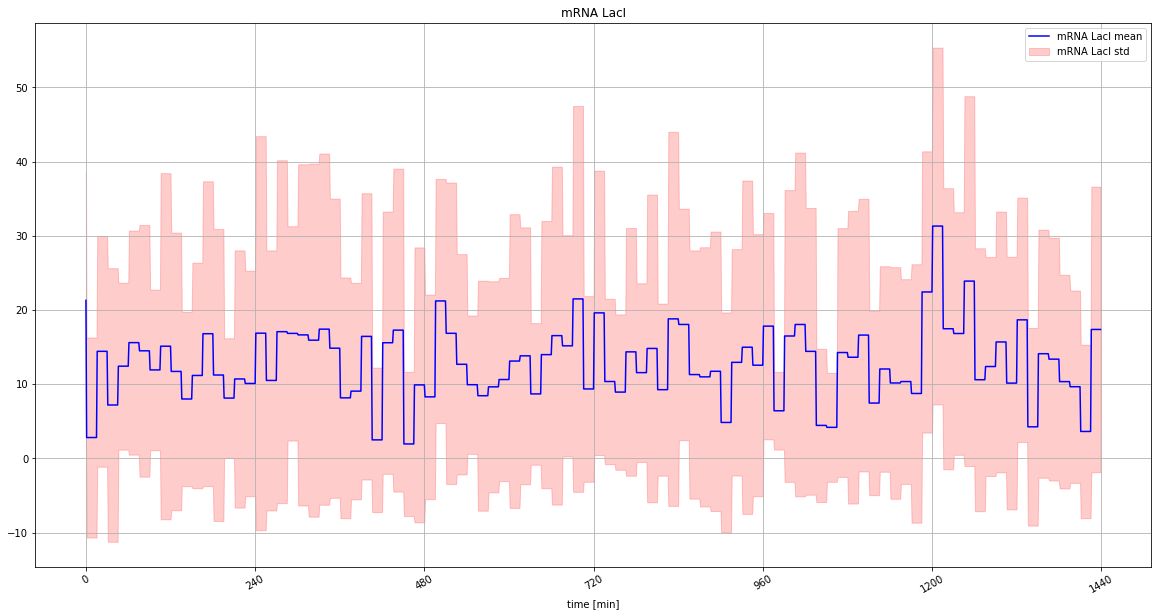

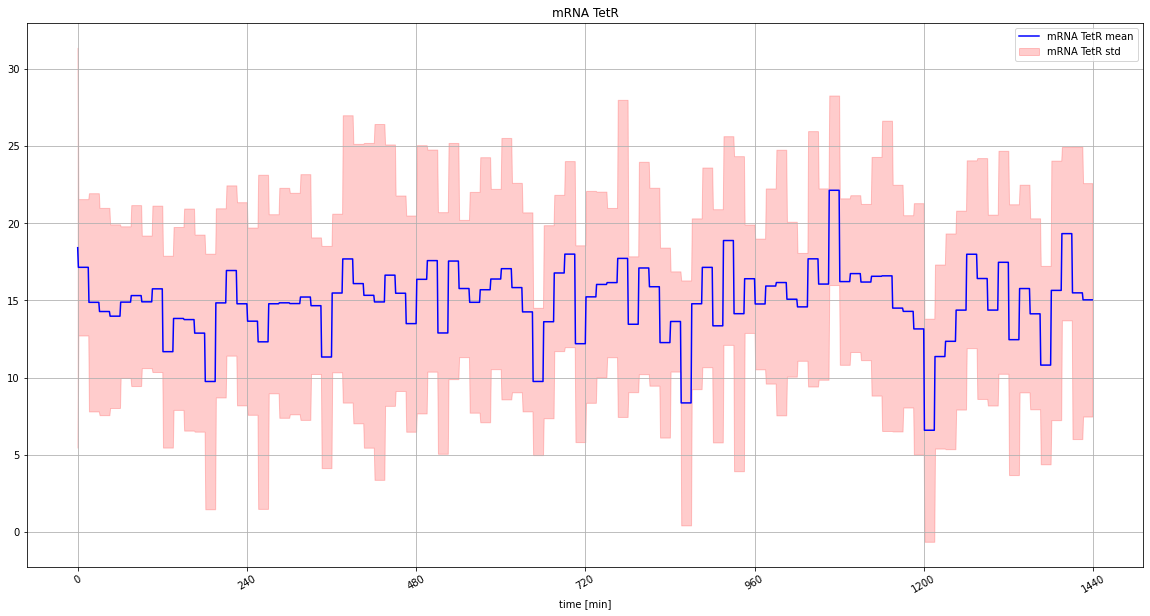

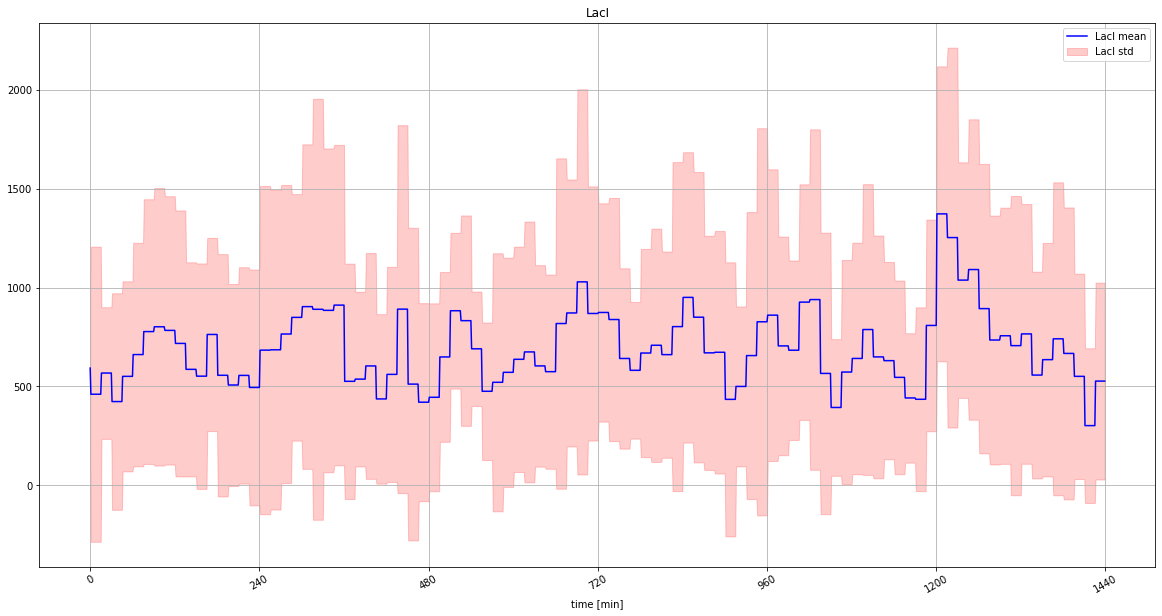

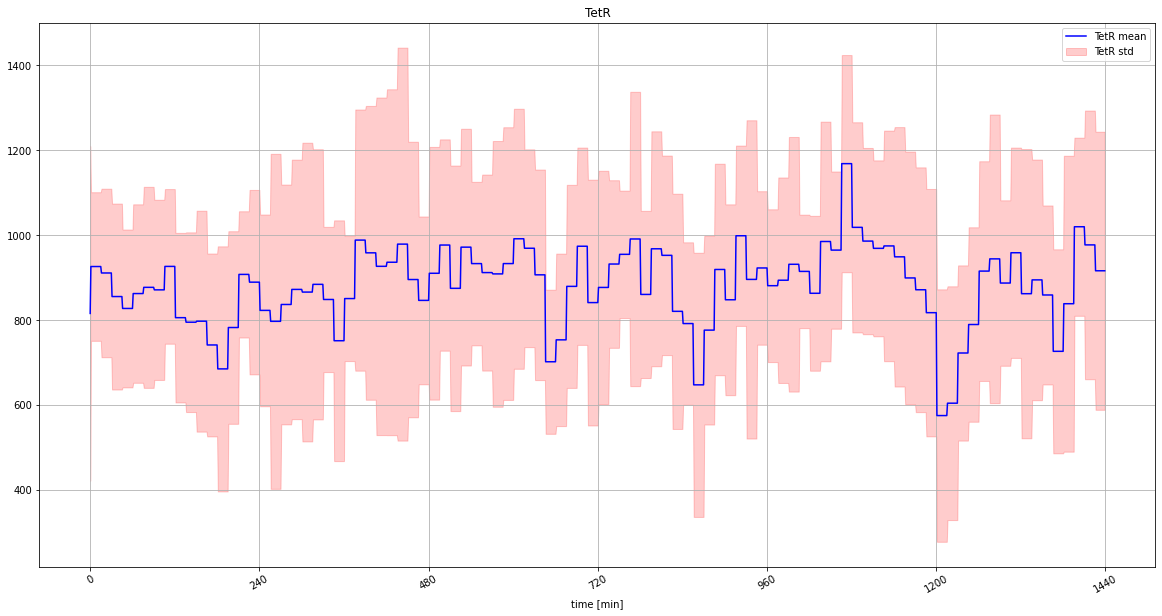

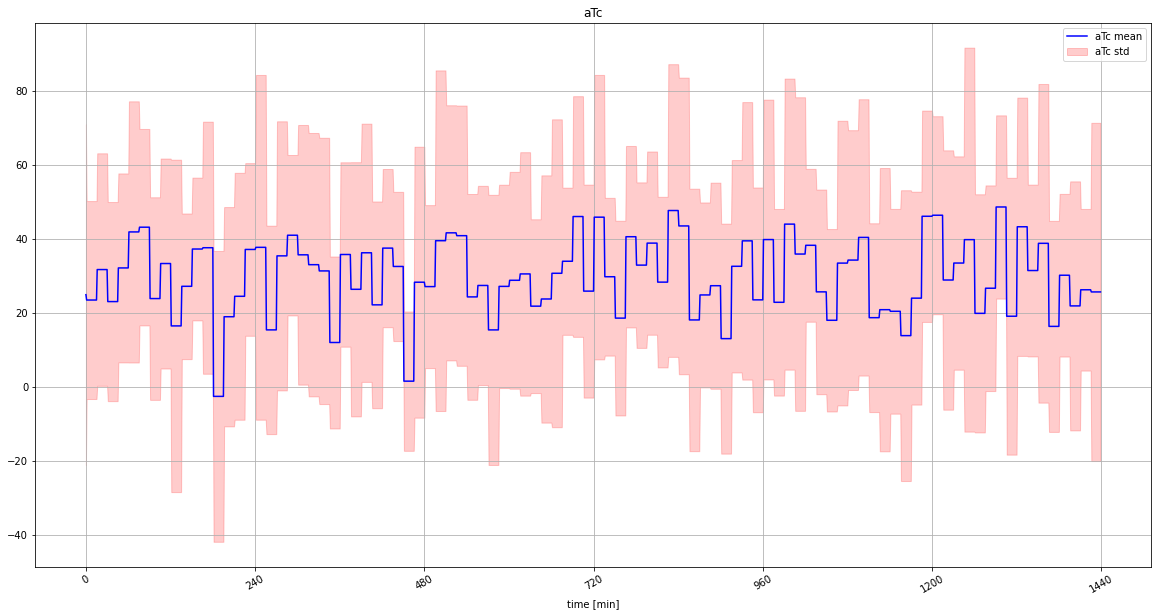

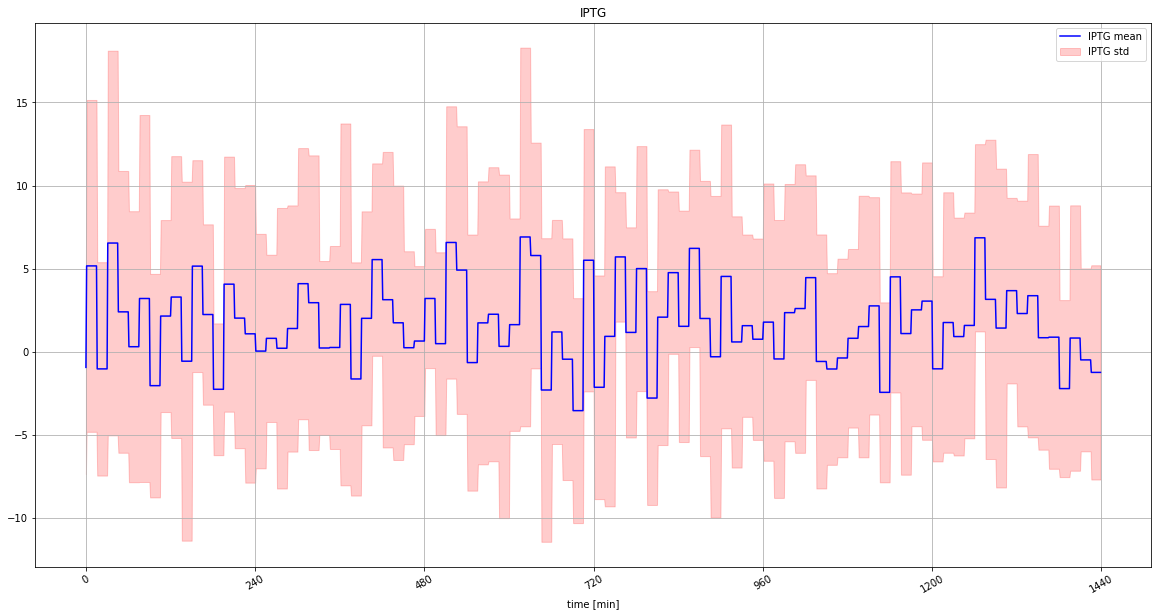

In [15]:
fig_x = 20
fig_y = 10

time = data['time']
xticks = [x for x in range(0, total_time + 1, 14400)]
xticks_label = [int(x/60) for x in range(0, total_time + 1, 14400)]

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('mRNA LacI')
axes.plot(time, x1_mean, color='b')
axes.fill_between(time, x1_mean - x1_std, x1_mean + x1_std, color='r', alpha=0.2)
axes.legend(['mRNA LacI mean', 'mRNA LacI std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/mRNA_LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))
axes.set_ylabel('')
axes.set_title('mRNA TetR')
axes.plot(time, x2_mean, color='b')
axes.fill_between(time, x2_mean - x2_std, x2_mean + x2_std, color='r', alpha=0.2)
axes.legend(['mRNA TetR mean', 'mRNA TetR std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/mRNA_TetR.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('LacI')
axes.plot(time, x3_mean, color='b')
axes.fill_between(time, x3_mean - x3_std, x3_mean + x3_std, color='r', alpha=0.2)
axes.legend(['LacI mean', 'LacI std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/LacI.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('TetR')
axes.plot(time, x4_mean, color='b')
axes.fill_between(time, x4_mean - x4_std, x4_mean + x4_std, color='r', alpha=0.2)
axes.legend(['TetR mean', 'TetR std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/TetR.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('aTc')
axes.plot(time, x5_mean, color='b')
axes.fill_between(time, x5_mean - x5_std, x5_mean + x5_std, color='r', alpha=0.2)
axes.legend(['aTc mean', 'aTc std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/aTc.png')

figure, axes = plt.subplots(1, figsize=(fig_x, fig_y))

axes.set_ylabel('')
axes.set_title('IPTG')
axes.plot(time, x6_mean, color='b')
axes.fill_between(time, x6_mean - x6_std, x6_mean + x6_std, color='r', alpha=0.2)
axes.legend(['IPTG mean', 'IPTG std'], loc='upper right')
axes.set_xlabel('time [min]')
axes.set_xticks(xticks, xticks_label, rotation=30)

figure.set_facecolor("white")
figure.savefig('./simulations/stochastic/mean_and_std/IPTG.png')
